In [1]:
!pip install split-folders

!pip install livelossplot

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.layers import Dense, Flatten, GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout
from keras.callbacks import CSVLogger
from livelossplot import PlotLossesKeras
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import keras.utils
from keras.utils.np_utils import to_categorical

In [4]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-jxzw1ha_
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-jxzw1ha_
  Resolved https://github.com/qubvel/segmentation_models to commit 94f624b7029deb463c859efbd92fa26f512b52b8
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 625.4 kB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=c205adddd202a6f39d4f0a93b4ff90f65778a62228245336238a720aa5436773
  Stored in directory: /tmp/pip-ephem-wheel-cache-evojwz9_/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [5]:
from tensorflow.keras.applications import ResNet50 as resnet

In [6]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "train.h5"

# Data

training_data_dir = "../input/31-classes/train/train" # 10 000 * 2
#validation_data_dir = "./output/val" # 2 500 * 2
test_data_dir = "../input/31-classes/val/val" # 12 500

In [7]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 31

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [8]:
# Data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2)
#validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [9]:
resn= resnet(weights = 'imagenet', include_top = False, input_shape = input_shape)
model = Sequential()
model.add(resn)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(31, activation = 'softmax'))

model.summary()

2022-07-23 23:12:47.376198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 23:12:47.493496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 23:12:47.494308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 23:12:47.495694: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 31)                63519     
Total params: 23,651,231
Trainable params: 23,598,111
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
sgd = SGD(learning_rate = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

In [13]:
training_generator = training_data_generator.flow_from_directory(training_data_dir, target_size=(224,224), batch_size=16, shuffle=True, subset="training")
validation_generator = training_data_generator.flow_from_directory(training_data_dir, target_size=(224,224), batch_size=8, subset="validation")# Data preparation


#validation_generator = validation_data_generator.flow_from_directory(
    #validation_data_dir,
    #target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    #batch_size=BATCH_SIZE,
    #class_mode="categorical")
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=1,
    class_mode="categorical", 
    shuffle=False)

Found 99615 images belonging to 31 classes.
Found 24885 images belonging to 31 classes.
Found 31137 images belonging to 31 classes.


In [14]:
hist = model.fit(training_generator,epochs = 20,validation_data=validation_generator, validation_steps=32,
    validation_batch_size=8, verbose='auto')
model.save_weights("resnetVal_weight.h5")

2022-07-23 23:15:09.261308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-23 23:15:15.061727: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6226/6226 [==============================] - 1702s 271ms/step - loss: 0.1462 - acc: 0.9568 - val_loss: 0.3391 - val_acc: 0.9258
Epoch 2/20
6226/6226 [==============================] - 1354s 218ms/step - loss: 0.0202 - acc: 0.9939 - val_loss: 0.3037 - val_acc: 0.9414
Epoch 3/20
6226/6226 [==============================] - 1350s 217ms/step - loss: 0.0107 - acc: 0.9968 - val_loss: 0.3250 - val_acc: 0.9336
Epoch 4/20
6226/6226 [==============================] - 1367s 220ms/step - loss: 0.0083 - acc: 0.9974 - val_loss: 0.3164 - val_acc: 0.9570
Epoch 5/20
6226/6226 [==============================] - 1377s 221ms/step - loss: 0.0056 - acc: 0.9982 - val_loss: 0.0851 - val_acc: 0.9727
Epoch 6/20
6226/6226 [==============================] - 1377s 221ms/step - loss: 0.0048 - acc: 0.9986 - val_loss: 0.1736 - val_acc: 0.9609
Epoch 7/20
6226/6226 [==============================] - 1413s 227ms/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0923 - val_acc: 0.9883
Epoch 8/20
6226/6226 [================

In [15]:
from sklearn.metrics import classification_report

In [16]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
#Prediction
#Finally predicting and checking the accuracy from the holdout data
predictions = model.predict(test_generator, verbose=1)
# Get most likely class

31137/31137 [==============================] - 363s 12ms/step


In [17]:
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 
print(predictions)
print(true_classes)
accuracy_score(true_classes, predictions)
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

[ 0  0  0 ... 30 30 30]
[ 0  0  0 ... 30 30 30]
                     precision    recall  f1-score   support

      Air Pollution       1.00      1.00      1.00       643
     Amniotic Fluid       1.00      1.00      1.00      1242
             Anther       1.00      1.00      1.00       987
         Atmosphere       1.00      0.97      0.98       728
        Brittleness       0.97      1.00      0.99       920
          Chemistry       0.97      0.99      0.98       976
Cogitive Pshycology       1.00      0.95      0.98       988
          Cognition       1.00      0.99      0.99       761
         Conclusion       1.00      1.00      1.00       816
       Condensation       1.00      1.00      1.00      1182
                DNA       1.00      1.00      1.00       392
   Digestive System       1.00      1.00      1.00      1587
             Energy       1.00      0.97      0.98       617
        Evaporation       1.00      1.00      1.00      1300
External Body Parts       0.96      

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


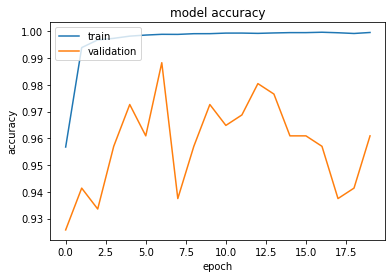

In [18]:
print(hist.history.keys())
epochs = range(1,35)
#  "Accuracy"
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("resnetVal accuracy.png")
plt.show()

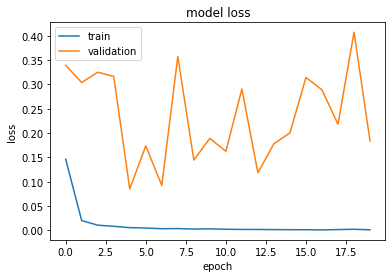

In [19]:
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("loss.png")
plt.show()